# Project 3 - Part 4: Hypothesis Testing

* The stakeholder's first question is: does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

    * They want you to perform a statistical test to get a mathematically-supported answer.
    
    * They want you to report if you found a significant difference between ratings.
    
        * If so, what was the p-value of your analysis?
        
        * And which rating earns the most revenue?
        
    * They want you to prepare a visualization that supports your finding.

In [105]:
import json 
import pandas as pd 
import numpy as np 
import seaborn as sns 
from scipy import stats 
import matplotlib.pyplot as plt

import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists 

### Loading Batches of Files with glob

In [52]:
import glob
q = "Data/final*.csv.gz"
final_files = glob.glob(q)
# Showing the first 5
final_files[:5]



['Data\\final_tmdb_data_2000.csv.gz',
 'Data\\final_tmdb_data_2001.csv.gz',
 'Data\\final_tmdb_data_2010.csv.gz',
 'Data\\final_tmdb_data_2011.csv.gz',
 'Data\\final_tmdb_data_2012.csv.gz']

In [53]:
## Loading and Concatenating the list of dfs with 1 line
df = pd.concat([pd.read_csv(file) for file in final_files])
df



,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.450,10.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.113,2300.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4901,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.100,12.0,NaN
4902,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
4903,tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN
4904,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.700,8.0,NaN


In [54]:
# remove ids that are 0
df = df.loc[ df['imdb_id']!='0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.450,10.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.113,2300.0,PG
5,tt0118852,0.0,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.642,53.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4901,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.100,12.0,NaN
4902,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
4903,tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN
4904,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.700,8.0,NaN


In [55]:
df = df.reset_index(drop=True)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
1,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.450,10.0,NaN
2,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
3,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.113,2300.0,PG
4,tt0118852,0.0,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.642,53.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40988,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.100,12.0,NaN
40989,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
40990,tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN
40991,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.700,8.0,NaN


In [10]:
## Saving the final combined dataframe
final_fname ='Data/tmdb_combined.csv.gz'
df.to_csv(final_fname, compression='gzip', index=False)



In [11]:
df = pd.read_csv(final_fname)
df



,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
1,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.450,10.0,NaN
2,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
3,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.113,2300.0,PG
4,tt0118852,0.0,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.642,53.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40989,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
40990,tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN
40991,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.700,8.0,NaN
40992,tt9915872,0.0,NaN,NaN,0.0,[],NaN,897433.0,en,The Last White Witch,...,0.0,97.0,[],Released,NaN,The Last White Witch,0.0,0.000,0.0,NaN


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40993 entries, 0 to 40992
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                40993 non-null  object 
 1   adult                  40993 non-null  float64
 2   backdrop_path          27134 non-null  object 
 3   belongs_to_collection  2766 non-null   object 
 4   budget                 40993 non-null  float64
 5   genres                 40993 non-null  object 
 6   homepage               10262 non-null  object 
 7   id                     40993 non-null  float64
 8   original_language      40993 non-null  object 
 9   original_title         40993 non-null  object 
 10  overview               40155 non-null  object 
 11  popularity             40993 non-null  float64
 12  poster_path            38075 non-null  object 
 13  production_companies   40993 non-null  object 
 14  production_countries   40993 non-null  object 
 15  re

In [57]:
# Check for missing values
df.isna().sum()

imdb_id                      0
adult                        0
backdrop_path            13859
belongs_to_collection    38227
budget                       0
genres                       0
homepage                 30731
id                           0
original_language            0
original_title               0
overview                   838
popularity                   0
poster_path               2918
production_companies         0
production_countries         0
release_date               608
revenue                      0
runtime                      0
spoken_languages             0
status                       0
tagline                  25790
title                        0
video                        0
vote_average                 0
vote_count                   0
certification            31752
dtype: int64

In [58]:
#Drop missing values from orders
df.dropna(inplace=True)
#Verify missing values dropped
df.isna().sum()

imdb_id                  0
adult                    0
backdrop_path            0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
id                       0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
vote_average             0
vote_count               0
certification            0
dtype: int64

### Hypothesis Testing for Ratings and Revnue 


#### State the Hypothesis and Null Hypothesis

Null hypothesis: There is no difference in revnue based on the rating of a movie.

Alternate Hypothesis: There is a significant difference in revnue based on the rating of a movie.

The ANOVA would the appriopriate test to perform:
we have more than 2 groups


Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

In [9]:
df['certification'].value_counts()

PG-13    174
R        146
PG       107
NR        32
G         23
NC-17      1
Name: certification, dtype: int64

In [41]:
#Keep only movies with rating of (G/PG/PG-13/R)
valid_certifications = ['G', 'PG', 'PG-13', 'R']
df = df[df['certification'].isin(valid_certifications)==True].copy()


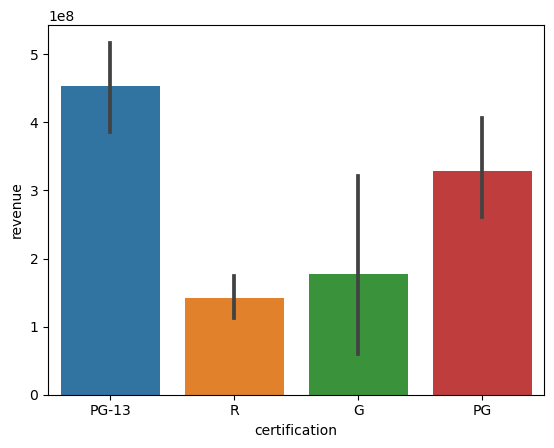

In [42]:
sns.barplot(data=df, x='certification',y='revenue');

#### Separate our Groups 

In [18]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['certification'].unique():
    ## Get series for group and rename
    data = df.loc[df['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()



dict_keys(['PG-13', 'R', 'G', 'PG'])

#### Testing for Normality 

In [19]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
PG-13,174.0,9.971975e-15,64.477995
R,146.0,4.174454e-18,80.035096
G,23.0,1.365066e-04,17.798275
PG,107.0,4.605664e-07,29.181618


In [20]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df



,n,p,test stat,sig
PG-13,174.0,9.971975e-15,64.477995,True
R,146.0,4.174454e-18,80.035096,True
G,23.0,1.365066e-04,17.798275,True
PG,107.0,4.605664e-07,29.181618,True


* The data is large enough to safely ignore the normaility test. 

#### Testing assumption of equal variance

In [25]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=17.01174661681371, pvalue=1.7727502679280683e-10)

* For stats.levene, the null hypothesis for thest is that both groups have equal variance. The p-value is less than the .05, so we reject the null hypothesis and conclude that our groups do not have equal variance.

* We did not meet the assumption of equal variance will neeed to do the kruskal wallis test. 

In [21]:
# perform the kruskal wallis test 
# note again the use of the * operator for convenience
result = stats.kruskal( *groups.values())
result


KruskalResult(statistic=54.022719236552994, pvalue=1.1096110647435093e-11)

* We failed the kurskal wallis test. 
* There is a significant difference in revnue based on ratings.

#### Tukey's Pairwise comparisons test

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['revenue']
labels = df['certification']



In [24]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,150862684.9216,0.2886,-68775618.4115,370500988.2547,False
G,PG-13,275879113.3808,0.0048,63854254.9848,487903971.7768,True
G,R,-35519396.8261,0.9738,-249904802.4785,178866008.8263,False
PG,PG-13,125016428.4592,0.0318,7613519.4836,242419337.4349,True
PG,R,-186382081.7477,0.0005,-307996244.6352,-64767918.8601,True
PG-13,R,-311398510.2069,0.0,-418653164.659,-204143855.7548,True


* We can see that there is no significant difference between groups that are compared with rated R movies. 


### Hypothesis Testing for Movies that are Greater than 2 hours and Revnue 

### State the Hypothesis and Null Hypothesis 

* Null hypothesis: There is no difference in revenue for movies that are longer than 2 hours.

* Alternate Hypothesis: There is a significant difference in revenue for movies that are longer than 2 hours.

The 2-sample t-test would the appriopriate test to perform:
   * We are measuring a numeric quantity (Discount)
   * and comparing 2 groups/samples

In [40]:
df['runtime'].value_counts()

100.0    19
90.0     17
97.0     15
98.0     13
103.0    13
         ..
138.0     1
150.0     1
165.0     1
139.0     1
181.0     1
Name: runtime, Length: 87, dtype: int64

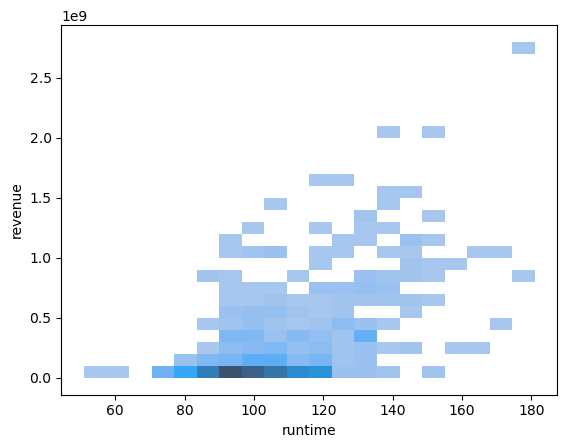

In [134]:
sns.histplot(data=df, x='runtime', y='revenue');

#### Separate into two groups ("under 2 hours and "over 2 hours")

In [101]:
#Create separate groups 
over_2hours = df.loc[df['runtime'] > 120.0].copy()
under_2hours = df.loc[df['runtime'] < 120.0].copy()

In [86]:
#define feature of interest 
over_2hours_group = over_2hours['revenue']
under_2hours_group = under_2hours['revenue']

#### Checking assumptions 

In [88]:
#Checking has_discount for outliers 
#testing for outliers for has_discount group
zscores_f = stats.zscore(over_2hours_group)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)

1

In [89]:
# remove outlier for has_discount
over_2hours_group = over_2hours_group[(np.abs(stats.zscore(over_2hours_group)) < 3)]

In [90]:
#Checking has_discount for outliers 
#testing for outliers for no_discount group
zscores_f = stats.zscore(under_2hours_group)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)


12

In [91]:
# remove outlier for no_discount group
under_2hours_group = under_2hours_group[(np.abs(stats.zscore(under_2hours_group)) < 3)]

In [92]:
result = stats.normaltest(under_2hours_group)
print(result)
# is the p-value less than 0.05?
result.pvalue < .05

NormaltestResult(statistic=107.34107007737467, pvalue=4.911145397771582e-24)


True

In [94]:
result = stats.normaltest(over_2hours_group)
print(result)
# is the p-value less than 0.05?
result.pvalue < .05


NormaltestResult(statistic=14.417833448156538, pvalue=0.0007399583004639079)


True

* Groups are large enough to safely ignore the normaility test. 

In [95]:
#testing for equal variance 
result = stats.levene(under_2hours_group, over_2hours_group)
result


LeveneResult(statistic=114.10234360945533, pvalue=5.876933329486047e-24)

* For stats.levene, the null hypothesis for thest is that both groups have equal variance. The p-value is less than the .05, so we reject the null hypothesis and conclude that our groups do not have equal variance.

* Since we did not meet the assumption of equal variance, we will run our stats.ttest_ind using equal_var=False. This will run a Welch's T-test, which is designed to account for unequal variance.

In [96]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(under_2hours_group, over_2hours_group, equal_var = False)
result


Ttest_indResult(statistic=-10.674662561570488, pvalue=1.1376090007452946e-19)

* The Welch's T-test returned a p-value < .05, so we will reject the null hypothesis and support the alternative hypothsis that there is a significant difference in revenue for movies that are over 2 hours.

### Hypothesis Testing for Ratings and Budget 

State the Hypothesis and Null Hypothesis
Null hypothesis: There is no difference in the budget based on the rating of a movie.

Alternate Hypothesis: There is a significant difference in the budget based on the rating of a movie.

The ANOVA would the appriopriate test to perform: we have more than 2 groups

In [137]:
#Keep only movies with rating of (G/PG/PG-13/R)
valid_certifications = ['G', 'PG', 'PG-13', 'R']
df = df[df['certification'].isin(valid_certifications)==True].copy()

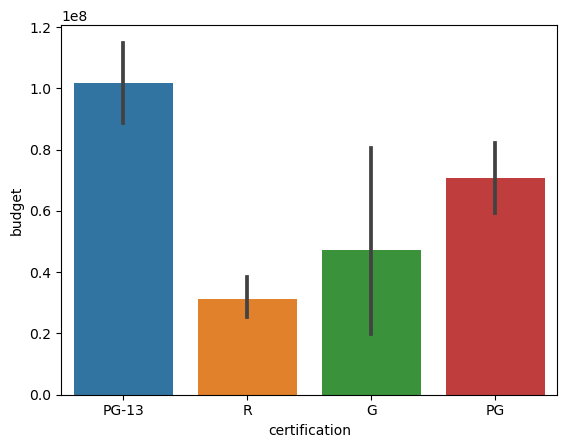

In [138]:
sns.barplot(data=df, x='certification',y='budget');

#### Separate the Groups 

In [139]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['certification'].unique():
    ## Get series for group and rename
    data = df.loc[df['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()


dict_keys(['PG-13', 'R', 'G', 'PG'])

#### Testing for Normality

In [140]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
PG-13,174.0,9.971975e-15,64.477995
R,146.0,4.174454e-18,80.035096
G,23.0,1.365066e-04,17.798275
PG,107.0,4.605664e-07,29.181618


In [141]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df


,n,p,test stat,sig
PG-13,174.0,9.971975e-15,64.477995,True
R,146.0,4.174454e-18,80.035096,True
G,23.0,1.365066e-04,17.798275,True
PG,107.0,4.605664e-07,29.181618,True


In [143]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=17.01174661681371, pvalue=1.7727502679280683e-10)

* For stats.levene, the null hypothesis for thest is that both groups have equal variance. The p-value is less than the .05, so we reject the null hypothesis and conclude that our groups do not have equal variance.

* We did not meet the assumption of equal variance will neeed to do the kruskal wallis test.

In [142]:
# perform the kruskal wallis test 
# note again the use of the * operator for convenience
result = stats.kruskal( *groups.values())
result

KruskalResult(statistic=54.022719236552994, pvalue=1.1096110647435093e-11)

* We failed the kurskal wallis test.
* There is a significant difference in revnue based on ratings.

In [144]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['revenue']
labels = df['certification']

In [145]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,150862684.9216,0.2886,-68775618.4115,370500988.2547,False
G,PG-13,275879113.3808,0.0048,63854254.9848,487903971.7768,True
G,R,-35519396.8261,0.9738,-249904802.4785,178866008.8263,False
PG,PG-13,125016428.4592,0.0318,7613519.4836,242419337.4349,True
PG,R,-186382081.7477,0.0005,-307996244.6352,-64767918.8601,True
PG-13,R,-311398510.2069,0.0,-418653164.659,-204143855.7548,True


* We can see that there is no significant difference between groups that are compared with rated R movies. 